# Combinations
Data: from 2015-01-01 to 2025-03-25 (current day) 

**Baseline**: S&P500 **Annual Return**: 11.04% 

**Try**: window_size = 220, rebalance_period = 1, max_selected_stocks = 100 **Results**: 18.49%

**Try**: window_size = 200, rebalance_period = 1, max_selected_stocks = 100 **Results**: 20.58%

**Try**: window_size = 180, rebalance_period = 1, max_selected_stocks = 100 **Results**: 20.77%

****
**Try**: window_size = 170, rebalance_period = 1, max_selected_stocks = 100 **Results**: 23.11%
****

**Try**: window_size = 160, rebalance_period = 1, max_selected_stocks = 100 **Results**: 22.96%

**Try**: window_size = 150, rebalance_period = 1, max_selected_stocks = 100 **Results**: 20.39%

**Try**: window_size = 140, rebalance_period = 1, max_selected_stocks = 100 **Results**: 17.69%

**Try**: window_size = 120, rebalance_period = 1, max_selected_stocks = 100 **Results**: 17.46%  

**Try**: window_size = 100, rebalance_period = 1, max_selected_stocks = 100 **Results**: 16.23%

**Try**: window_size = 80, rebalance_period = 1, max_selected_stocks = 100 **Results**: 12.33%

**Try**: window_size = 60, rebalance_period = 1, max_selected_stocks = 100 **Results**: 12.68%

**Try**: window_size = 40, rebalance_period = 1, max_selected_stocks = 100 **Results**: 

In [57]:
import os
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Set the directory and initial capital
directory = "/home/jesse/Projects/CWP_RL/02_MVO_Multi_Assets/SP500_15_25"
initial_capital = 10000
min_data_length = 2500  # At least 2500 rows of data
window_size = 170  # Number of days to use for calculating MVO
rebalance_period = 1  # Rebalance the portfolio every 1 day
max_selected_stocks = 100  # Maximum number of stocks to hold

print("✅ Initialization complete!")


✅ Initialization complete!


In [58]:
def load_data(directory):
    stock_data = {}
    for ticker in os.listdir(directory):
        if ticker.endswith(".csv"):
            file_path = os.path.join(directory, ticker)
            df = pd.read_csv(file_path)
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
            df.sort_index(inplace=True)

            # Only select stocks with enough data (>= min_data_length)
            if df.shape[0] >= min_data_length:
                # Store both Open and Close prices for each stock
                stock_data[ticker.replace(".csv", "")] = df[['Open', 'Close']]
    
    return stock_data

# Load the stock data
stock_data = load_data(directory)

# Preview the data of the first 5 stocks
for ticker in list(stock_data.keys())[:5]:
    print(f"📈 Sample data for {ticker}:\n", stock_data[ticker].head())

print(f"\n✅ Successfully loaded data for {len(stock_data)} stocks!")


📈 Sample data for TMUS:
                  Open      Close
Date                            
2015-01-02  26.501368  26.696949
2015-01-05  26.520928  26.335125
2015-01-06  26.432915  26.276449
2015-01-07  26.648057  27.625967
2015-01-08  27.694420  28.378958
📈 Sample data for CHRW:
                  Open      Close
Date                            
2015-01-02  58.290494  57.503941
2015-01-05  57.137927  54.980747
2015-01-06  55.993143  54.264286
2015-01-07  54.381086  54.287632
2015-01-08  55.035257  56.725174
📈 Sample data for COO:
                  Open      Close
Date                            
2015-01-02  40.631244  40.064980
2015-01-05  39.780600  39.755653
2015-01-06  39.867910  39.194378
2015-01-07  39.548606  40.466602
2015-01-08  40.676137  40.631237
📈 Sample data for ES:
                  Open      Close
Date                            
2015-01-02  38.026744  38.175926
2015-01-05  38.190129  37.834938
2015-01-06  37.927288  37.856251
2015-01-07  38.147510  38.410351
2015-01-08  

In [59]:
# Initialize an empty list to store returns for each stock
returns_list = []

for ticker in stock_data:
    # Get the daily returns for 'Close' prices
    stock_returns = stock_data[ticker].pct_change().dropna()
    
    # Add the 'Close' returns to the list
    returns_list.append(stock_returns['Close'])

# Concatenate all the returns DataFrames along columns (axis=1)
returns = pd.concat(returns_list, axis=1)

# Set column names as stock tickers
returns.columns = stock_data.keys()

# Preview the data
print("📊 Example of returns data (first 5 rows):\n", returns.head())

print("\n✅ Daily returns calculation completed!")


📊 Example of returns data (first 5 rows):
                 TMUS      CHRW       COO        ES      HSIC      MKTX  \
Date                                                                     
2015-01-05 -0.013553 -0.043879 -0.007721 -0.008932 -0.008989 -0.019332   
2015-01-06 -0.002228 -0.013031 -0.014118  0.000563 -0.005826 -0.019278   
2015-01-07  0.051358  0.000430  0.032459  0.014637  0.027667  0.009016   
2015-01-08  0.027257  0.044901  0.004068  0.001665  0.014074  0.050242   
2015-01-09  0.007925 -0.010708 -0.006262 -0.012555  0.005053 -0.002650   

                 UDR        ED      MCHP       EOG  ...       EMN       KEY  \
Date                                                ...                       
2015-01-05  0.010520 -0.009496 -0.022286 -0.060277  ... -0.034519 -0.030303   
2015-01-06  0.005678  0.005631 -0.019376 -0.028496  ... -0.004198 -0.030506   
2015-01-07  0.006901  0.014831  0.005579 -0.006294  ... -0.006392  0.007674   
2015-01-08  0.001884  0.006263  0.031900  0

In [60]:
# Calculate annualized returns
def annualized_returns(returns, trading_days=252):
    return returns.mean() * trading_days

# Calculate the annualized covariance matrix
def annualized_covariance(returns, trading_days=252):
    return returns.cov() * trading_days

# Objective function: Maximize Sharpe Ratio
def objective(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    portfolio_return = np.sum(weights * mean_returns)
    
    # Calculate portfolio volatility (standard deviation)
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    
    # Handle negative or NaN variance (safety check)
    if portfolio_variance < 0 or np.isnan(portfolio_variance):
        portfolio_volatility = 1e-6  # A small value to avoid sqrt calculation error
    else:
        portfolio_volatility = np.sqrt(portfolio_variance)

    # Calculate the Sharpe Ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    return -sharpe_ratio  # Since `minimize` is minimizing, return the negative of the Sharpe Ratio

print("✅ MVO related functions have been defined!")


✅ MVO related functions have been defined!


In [61]:
# Initialize
portfolio_value = initial_capital
portfolio_values = []
weights_history = []

rebalance_dates = []  # Store the dates of each rebalance

for i in range(window_size, len(returns), rebalance_period):
    # Record the rebalance date (use i-1, as it refers to the data from the previous day)
    rebalance_dates.append(returns.index[i - 1])  

    # Get window data
    window_returns = returns.iloc[i - window_size:i]

    # Calculate annualized returns and standard deviation
    mean_returns = annualized_returns(window_returns)
    std_returns = window_returns.std() * np.sqrt(252)  # Annualized standard deviation

    # Calculate Sharpe Ratio and select the top max_selected_stocks stocks
    sharpe_ratios = mean_returns / std_returns
    top_stocks = sharpe_ratios.nlargest(max_selected_stocks).index  # Select the top max_selected_stocks stocks

    # Perform MVO only for selected stocks
    selected_returns = window_returns[top_stocks]
    mean_returns = mean_returns[top_stocks]
    cov_matrix = annualized_covariance(selected_returns)

    # Add a regularization term to prevent singular covariance matrix
    cov_matrix += np.eye(len(mean_returns)) * 1e-6  

    # Initialize weights
    num_assets = len(mean_returns)
    initial_weights = np.ones(num_assets) / num_assets

    # Constraints: Weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

    # Bounds for weights (0 ~ 1)
    bounds = tuple((0, 1) for _ in range(num_assets))

    # Perform optimization
    optimized_result = minimize(objective, initial_weights, args=(mean_returns, cov_matrix),
                                method='SLSQP', bounds=bounds, constraints=constraints)

    # Get optimal weights
    optimal_weights = optimized_result.x
    weights_history.append(pd.Series(optimal_weights, index=top_stocks, name=returns.index[i - 1]))

    # Calculate portfolio return (based on actual returns for the next period)
    recent_returns = returns.iloc[i:i + rebalance_period][top_stocks].mean()
    portfolio_return = np.sum(optimal_weights * recent_returns)
    portfolio_value *= (1 + portfolio_return)
    portfolio_values.append(portfolio_value)

# Link portfolio values with dates
portfolio_results = pd.DataFrame({'Date': rebalance_dates, 'Portfolio Value': portfolio_values})

# Record portfolio weights
weights_df = pd.DataFrame(weights_history)

print("✅ MVO Calculation Complete, Dates and Weights Recorded!")

# Print Results
print(portfolio_results.head())
print(weights_df.head())


✅ MVO Calculation Complete, Dates and Weights Recorded!
        Date  Portfolio Value
0 2015-09-04     10231.479916
1 2015-09-08     10121.802238
2 2015-09-09     10236.420936
3 2015-09-10     10334.866775
4 2015-09-11     10276.844806
                 CZR      HOLX      TMUS      DXCM           VMC  \
2015-09-04  0.184725  0.075403  0.109591  0.112773  4.203699e-15   
2015-09-08  0.163945  0.083341  0.129284  0.095486  3.416520e-15   
2015-09-09  0.171852  0.074590  0.097284  0.108446  6.278667e-15   
2015-09-10  0.173769  0.075090  0.077318  0.141260  8.274080e-15   
2015-09-11  0.182764  0.078347  0.048598  0.138013  3.894734e-15   

                     STZ      NFLX      AMZN           GPN       ROL  ...  \
2015-09-04  6.396176e-02  0.034363  0.089392  1.674993e-15  0.000373  ...   
2015-09-08  3.601470e-15  0.036761  0.098293  2.409804e-15  0.005753  ...   
2015-09-09  4.778761e-15  0.051631  0.114690  5.307780e-15  0.055437  ...   
2015-09-10  5.550110e-15  0.052728  0.116360  5

In [62]:
# Generate DataFrame for weights and portfolio values
weights_df = pd.DataFrame(weights_history)
portfolio_values_df = pd.DataFrame(portfolio_values, columns=['Portfolio Value'], index=weights_df.index)

# Save results
weights_df.to_csv("optimal_weights_history.csv")
portfolio_values_df.to_csv("portfolio_value_history.csv")

print("✅ Results have been saved!")


✅ Results have been saved!


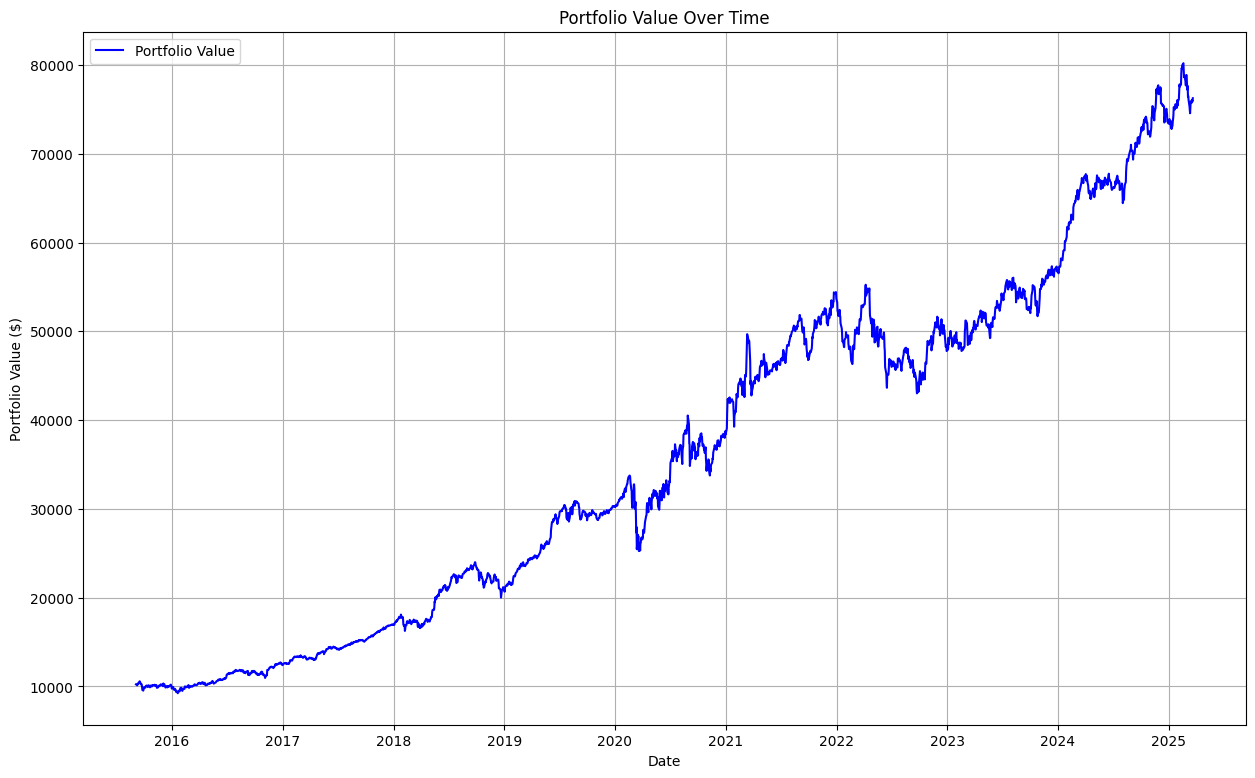

✅ Graph Finished


In [63]:
# Create MVO Portfolio Returns
plt.figure(figsize=(15, 9))
plt.plot(portfolio_values_df.index, portfolio_values_df['Portfolio Value'], label='Portfolio Value', color='b')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()

print("✅ Graph Finished")


[*********************100%***********************]  1 of 1 completed


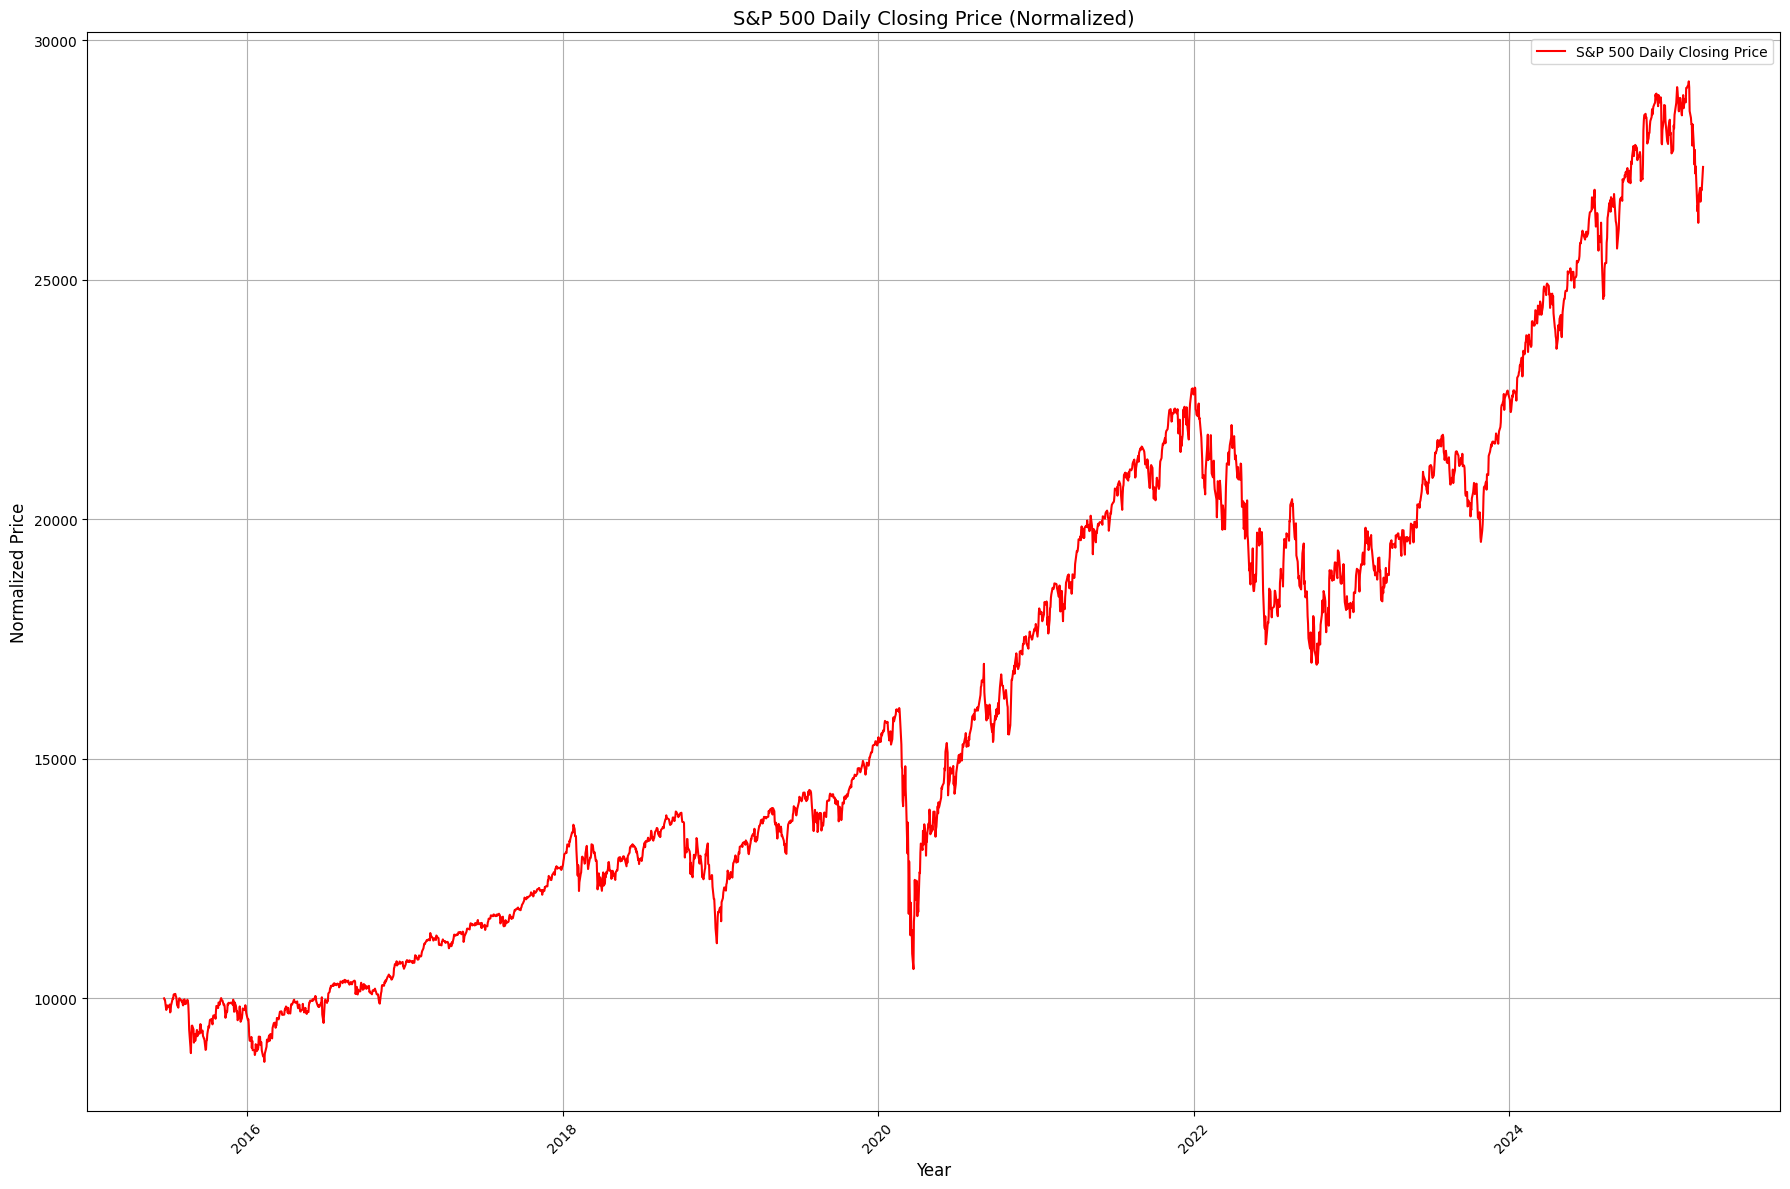

In [64]:
import matplotlib.dates as mdates
import yfinance as yf

# Download S&P 500 daily closing price data
data = yf.download('^GSPC', start='2015-06-24', end='2025-03-25')

# Get closing prices
close_prices = data['Close']

# Normalize closing prices: set the starting point to 10,000
normalized_close = 10000 * (close_prices / close_prices.iloc[0])

# Create chart
plt.figure(figsize=(18, 12))
plt.plot(close_prices.index, normalized_close, label='S&P 500 Daily Closing Price', color='r')

# Set x-axis to years
plt.xlabel('Year', fontsize=12)
plt.ylabel('Normalized Price', fontsize=12)
plt.title('S&P 500 Daily Closing Price (Normalized)', fontsize=14)

# Format x-axis: display a tick every 2 years
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # One tick every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display only the year

# Beautify the plot
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # Rotate ticks to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()
